In [16]:
import warnings
warnings.filterwarnings('ignore')
import pydot_ng as pydot
pydot.InvocationException(1)

pydot_ng.InvocationException(1)

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot  as plt
import keras_tuner as kt

In [552]:
Stock = pd.read_csv('Dataset/9237.KL.csv')

# Calculation of historical moving averages of closing price (10 and 30 days of trading)
def MA(df, period):
    MA = pd.Series(df['Close'].rolling(period, min_periods=period).mean(), name='MA_' + str(period))
    return MA

Stock['MA10'] = MA(Stock, 10)
Stock['MA30'] = MA(Stock, 30)

#calculation of exponential moving average of closing price (10 and 30 days of trading)
def EMA(df, period):
    EMA = pd.Series(df['Close'].ewm(span=period, min_periods=period).mean(), name='EMA_' + str(period))
    return EMA

Stock['EMA10'] = EMA(Stock, 10)
Stock['EMA30'] = EMA(Stock, 30)


#Calculation of closing price momentum (10 and 30 days of trading)
def MOM(df, period):   
    MOM = pd.Series(df.diff(period), name='Momentum_' + str(period))   
    return MOM

Stock['MOM10'] = MOM(Stock['Close'], 10)
Stock['MOM30'] = MOM(Stock['Close'], 30)

In [553]:
# Creating two columns SMA and LMA to label our dataset
# SMA (Short Moving Average)- The average of the closing price from the next five days in the future
# LMA (Long Moving Average)- The average of the closing price from the last ten days and the next five days in the future

full_data = Stock
full_data['SMA'] = ""
full_data['LMA'] = ""

for ind in range(0, (full_data.shape[0]-5)):
    sma_frame = full_data['Close'].iloc[ind+1:ind+6]
    full_data['SMA'].iloc[ind] = sma_frame.mean()
  
    lma_frame_one = full_data['Close'].iloc[ind-10:ind]
    lma_frame_two = full_data['Close'].iloc[ind+1:ind+6]

    if (lma_frame_one.sum() == 0):
        full_data['LMA'].iloc[ind] = np.NaN
    else: 
        full_data['LMA'].iloc[ind] = (lma_frame_one.sum() + lma_frame_two.sum())/15

full_data['SMA'] = full_data['SMA'].replace('', np.NaN)
full_data['LMA'] = full_data['LMA'].replace('', np.NaN)

#Dropping any empty fields of data
full_data = full_data.dropna(axis=0)
print(full_data.head())

          Date     Open     High      Low    Close  Adj Close  Volume  \
30  2013-10-01  0.10625  0.11500  0.10500  0.11500   0.110604    8000   
31  2013-10-02  0.11250  0.11500  0.10625  0.11125   0.106997  590400   
32  2013-10-03  0.10625  0.10625  0.10625  0.10625   0.102188    2800   
33  2013-10-04  0.10500  0.11125  0.10500  0.11125   0.106997   56400   
34  2013-10-07  0.10500  0.11250  0.10375  0.11125   0.106997  524000   

        MA10      MA30     EMA10     EMA30    MOM10    MOM30      SMA  \
30  0.111250  0.112125  0.110708  0.111507  0.00250 -0.00875  0.10925   
31  0.111125  0.111833  0.110807  0.111488 -0.00125 -0.00875  0.11000   
32  0.110375  0.111458  0.109977  0.111108 -0.00750 -0.01125  0.11175   
33  0.110000  0.111333  0.110209  0.111118 -0.00375 -0.00375  0.11150   
34  0.109625  0.111250  0.110398  0.111128 -0.00375 -0.00250  0.11100   

         LMA  
30  0.110417  
31  0.110833  
32  0.111333  
33  0.110750  
34  0.110333  


In [554]:
#Creating target class - Signal
# The signal on a given trading day represents either 1-Buy or 0-Sell 
# The signal is calculated by comparing the future SMA and intermediate LMA
labelled_data = full_data
labelled_data['signal'] = np.where(labelled_data['SMA'] > labelled_data['LMA'], 1.0, 0.0)

#Dropping the SMA and LMA columns to avoid data leakage
labelled_data  = labelled_data.drop(columns = ['SMA', 'LMA'])
print(labelled_data.head(30))

          Date     Open     High      Low    Close  Adj Close   Volume  \
30  2013-10-01  0.10625  0.11500  0.10500  0.11500   0.110604     8000   
31  2013-10-02  0.11250  0.11500  0.10625  0.11125   0.106997   590400   
32  2013-10-03  0.10625  0.10625  0.10625  0.10625   0.102188     2800   
33  2013-10-04  0.10500  0.11125  0.10500  0.11125   0.106997    56400   
34  2013-10-07  0.10500  0.11250  0.10375  0.11125   0.106997   524000   
35  2013-10-08  0.10625  0.10625  0.10625  0.10625   0.102188    16000   
36  2013-10-09  0.11750  0.11750  0.11000  0.11500   0.110604   354400   
37  2013-10-10  0.11500  0.11500  0.11500  0.11500   0.110604    96000   
38  2013-10-11  0.11250  0.11250  0.11000  0.11000   0.105795    51200   
39  2013-10-14  0.11000  0.11625  0.10875  0.10875   0.104593   132400   
40  2013-10-16  0.10875  0.12875  0.10625  0.10625   0.102188   336800   
41  2013-10-17  0.10625  0.11250  0.10625  0.10875   0.104593   328800   
42  2013-10-18  0.10750  0.11250  0.10

In [555]:
# Creating the MinMaxScaler Object
scaler = MinMaxScaler()

temp = labelled_data.drop(['Date', 'signal'], axis=1)
cols = temp.columns

#Creating scaled data
temp = scaler.fit_transform(temp)

#Generating input_df which will be used for model training and predictions
input_df = pd.concat([labelled_data['Date'],pd.DataFrame(temp, columns = cols),
                      labelled_data['signal']], 
                      axis=1, ignore_index=False)

input_df = input_df.dropna(axis=0)
print(input_df.head())
print(input_df.tail())

          Date      Open     High       Low     Close  Adj Close    Volume  \
30  2013-10-01  0.005307  0.00756  0.017327  0.007796   0.007563  0.001340   
31  2013-10-02  0.006634  0.00714  0.017822  0.005630   0.005462  0.000928   
32  2013-10-03  0.007519  0.00714  0.016832  0.006496   0.006302  0.001158   
33  2013-10-04  0.005750  0.00714  0.017327  0.005197   0.005042  0.000191   
34  2013-10-07  0.006192  0.00672  0.017327  0.006929   0.006722  0.000580   

        MA10      MA30     EMA10     EMA30     MOM10     MOM30  signal  
30  0.008371  0.003696  0.007068  0.005209  0.354263  0.385816     0.0  
31  0.007710  0.003841  0.006656  0.005194  0.347926  0.384924     0.0  
32  0.007270  0.004109  0.006527  0.005265  0.350230  0.387600     1.0  
33  0.006664  0.004233  0.006109  0.005204  0.348502  0.384478     1.0  
34  0.006443  0.004439  0.006183  0.005318  0.352535  0.386262     1.0  
            Date      Open      High       Low     Close  Adj Close    Volume  \
2427  2023-0

In [556]:
# Splitting entire data to create Training and Testing Data
# We will need to split the training and testing data into equivalent 
# time steps to train the Model

# Creating Training and Testing indices
train_data_size = int((0.7)*(input_df.shape[0]))
test_data_size = int(input_df.shape[0] - train_data_size)

# Allocating data instances to training and testing sets, excluding the date
train_data = input_df.iloc[0:train_data_size,1:]
test_data = input_df.iloc[train_data_size:input_df.shape[0],1:]


full_training_data = train_data # Used during model prediction
full_test_data = test_data  # Used during model prediction

# Creating numpy arrays from dataframes for future processing
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)
print(test_data.shape)

(1681, 13)
(721, 13)


In [557]:
# Creating X_train and y_train
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_train = []
y_train = []

time_step = 5
label_col = (train_data.shape[1]-1)

for i in range(time_step, train_data.shape[0]):
    X_train.append(train_data[i-time_step:i,:label_col])
    y_train.append(train_data[i,label_col])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print('\nShapes of X_train and Y_train:\n')
print(X_train.shape)
print(y_train.shape)

print('\nFirst Element in X_train and Y_train:\n')
print(X_train[0])
print(y_train[0])


Shapes of X_train and Y_train:

(1676, 5, 12)
(1676,)

First Element in X_train and Y_train:

[[5.30738611e-03 7.55984880e-03 1.73267327e-02 7.79558250e-03
  7.56278968e-03 1.34039074e-03 8.37096597e-03 3.69613248e-03
  7.06817630e-03 5.20866567e-03 3.54262673e-01 3.85816236e-01]
 [6.63423264e-03 7.13985720e-03 1.78217822e-02 5.63014292e-03
  5.46205360e-03 9.28146120e-04 7.71010023e-03 3.84067398e-03
  6.65576368e-03 5.19371735e-03 3.47926267e-01 3.84924175e-01]
 [7.51879699e-03 7.13985720e-03 1.68316832e-02 6.49631875e-03
  6.30220824e-03 1.15809760e-03 7.26952308e-03 4.10910818e-03
  6.52660917e-03 5.26549204e-03 3.50230415e-01 3.87600357e-01]
 [5.74966829e-03 7.13985720e-03 1.73267327e-02 5.19705500e-03
  5.04197628e-03 1.90633350e-04 6.66372949e-03 4.23300089e-03
  6.10852743e-03 5.20403357e-03 3.48502304e-01 3.84478145e-01]
 [6.19195046e-03 6.71986560e-03 1.73267327e-02 6.92940667e-03
  6.72228556e-03 5.80240258e-04 6.44344091e-03 4.43948874e-03
  6.18300738e-03 5.31778083e-03 3

In [558]:
# Creating X_test and y_test
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_test = []
y_test = []

# Gathering the last five days of training data as this 
# will be used to predict the first few labels in y_test
last_5_days = full_training_data.tail()
test_data_df = pd.concat([last_5_days, full_test_data], ignore_index=True)

for i in range(time_step, test_data_df.shape[0]):
    X_test.append(test_data_df.iloc[i-time_step:i,:label_col])
    y_test.append(test_data_df.iloc[i, label_col])

X_test, y_test = np.array(X_test), np.array(y_test)
print('\nShapes of X_test and Y_test:\n')
print(X_test.shape)
print(y_test.shape)

print('\nFirst Element in X_test and Y_test:\n')
print(X_test[0])
print(y_test[0])



Shapes of X_test and Y_test:

(721, 5, 12)
(721,)

First Element in X_test and Y_test:

[[0.22158337 0.22553549 0.25940594 0.23170204 0.22478191 0.04367053
  0.25806807 0.28774082 0.27446961 0.29737821 0.39861751 0.41926851]
 [0.24104379 0.23645527 0.27326733 0.22996968 0.22310125 0.02756677
  0.26247384 0.2896405  0.2793814  0.30038503 0.40092166 0.42283675]
 [0.23750553 0.23141537 0.27425743 0.23863144 0.23150419 0.01423674
  0.26721005 0.29211836 0.28548287 0.30404232 0.40437788 0.4353256 ]
 [0.24546661 0.24233515 0.28514851 0.24989173 0.2424283  0.03735103
  0.27370856 0.29525697 0.29318253 0.30856144 0.42281106 0.44959857]
 [0.26934985 0.26417472 0.2950495  0.26028584 0.2525119  0.07755918
  0.2815288  0.29847818 0.30198153 0.31380233 0.43663594 0.45138269]]
1.0


In [559]:
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are your training data
# You can adjust the test_size parameter to control the proportion of the dataset to include in the test split
# For example, setting test_size=0.2 means that 20% of the data will be used for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Now X_train and y_train are used for training, and X_val and y_val are used for validation

In [560]:
# Model definition
def build_model():

    model = Sequential()

    model.add(LSTM(units = 30, activation = 'relu',input_shape = (X_train.shape[1], X_train.shape[2])))
    
    model.add(Dropout(0.2))
   
    model.add(Dense(units = 10, activation = 'relu'))
           
    model.add(Dense(units = 1, activation = 'sigmoid'))
   
    print(model.summary())

    return model

# Model Compile
def compile_model(model):

    met = [keras.metrics.BinaryAccuracy(name='accuracy'),keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
    
    model.compile(optimizer='adam', loss = BinaryCrossentropy(), metrics = met)

    return model

# Model Training
def train_model(model, X_train, Y_train):
    
    batch_size = 32
    epochs = 80

    #Capturing the unique counts of 0 and 1 signal classes
    (unique,counts) = np.unique(Y_train, return_counts=True)
    frequencies = np.asarray((unique, counts)).T

    neg = frequencies[0][1]
    pos= frequencies[1][1]
    total = neg+pos

    #Calculating weights for teh two binary classes
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    
    #Defining parameters for the class weights
    cw = {0: weight_for_0, 1: weight_for_1}
       
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

    return model, history

# Model Evaluation and Results Evaluation
def eval_model(m, test_X, test_y):

    y_pred = m.predict(test_X)
    y_pred = y_pred.flatten()
    
    # Round predictions to two decimal places
    y_pred_rounded = np.round(y_pred, decimals=2)
    
    print('PREDICTED SIGNAL: \n')

    # Print head (first few elements) of the array
    print(y_pred_rounded[:5])  # Print first 5 elements

    # Print tail (last few elements) of the array
    print(y_pred_rounded[-5:])  # Print last 5 elements

    def map_signal(prediction):
        if prediction <= 0.2:
            return 'Strong Sell'
        elif prediction <= 0.4:
            return 'Sell'
        elif prediction <= 0.6:
            return 'Neutral'
        elif prediction <= 0.8:
            return 'Buy'
        else:
            return 'Strong Buy'

# Apply the function to each rounded prediction
    signals = [map_signal(pred) for pred in y_pred_rounded]

# Print the signals
    print('Head of the signal array:')
    print(signals[:10])

# Print the tail of the array
    print('\nTail of the signal array:')
    print(signals[-10:])
    
    print('CONFUSION MATRIX: \n')
    unique_label = np.unique([test_y, y_pred.round()])
    cmtx = pd.DataFrame(
    confusion_matrix(test_y, y_pred.round(), labels=unique_label), 
    index=['  true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label])
    print(cmtx)


    print('\nCLASSFICATION REPORT: \n')
    print(classification_report(test_y, y_pred.round()))

    # Visualising the results
    print('\nMODEL PREDICTIONS VS ACTUAL: \n')
    plt.figure(figsize=(14,5))
    plt.plot(test_y, color = 'red', label = 'Actual Buy/Sell Signal ')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Signal')
    plt.title('1023.KL LSTM Stock Buy/Sell Prediction')
    plt.xlabel('Time')
    plt.ylabel('1023.KL Stock Signal')
    plt.legend(loc='best')
    plt.show()
   
    return None

In [561]:
# Class Imbalance
(unique,counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('Training Instances with Class 0:  ' + str(frequencies[0][1]))
print('Training Instances with Class 1:  ' + str(frequencies[1][1]))
total = int(frequencies[0][1]) + int(frequencies[1][1])
print('Total Training instances:  '+str(total))

Training Instances with Class 0:  672.0
Training Instances with Class 1:  668.0
Total Training instances:  1340


In [562]:
# Executing model building, compiling and training 
# During model training, we print the 
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, y_train)

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 30)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,481 (21.41 KB)

 Trainable params: 5,481 (21.41 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/80


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5094 - auc: 0.5282 - loss: 0.6923 - precision: 0.5090 - recall: 0.7358
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5127 - auc: 0.5465 - loss: 0.6886 - precision: 0.5128 - recall: 0.7326
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5576 - auc: 0.5877 - loss: 0.6816 - precision: 0.5727 - recall: 0.5334
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5813 - auc: 0.5850 - loss: 0.6746 - precision: 0.6240 - recall: 0.3674
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5555 - auc: 0.5682 - loss: 0.6771 - precision: 0.5899 - recall: 0.3593
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5764 - auc: 0.5585 - loss: 0.6800 - precision: 0.6238 - recall: 0.3306
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5691 - auc: 0.5766 - loss: 0.6749 - precision: 0.6130 - recall: 0.3737
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.57


MODEL TRAINING RESULTS



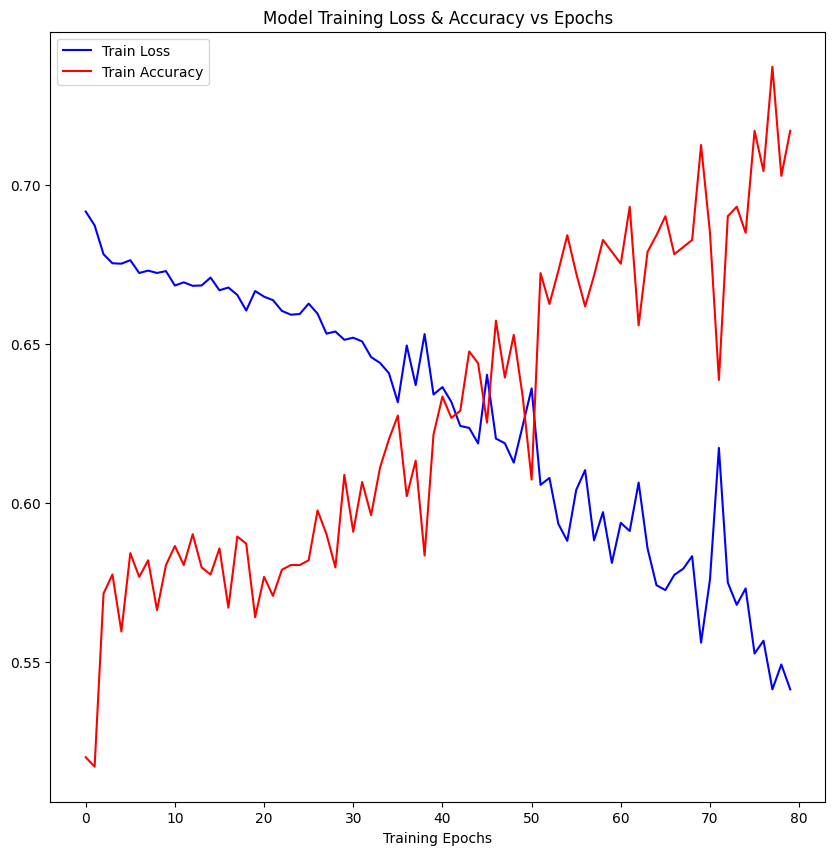

In [563]:
# Plotting Training loss vs Epochs 
def plot_curves(history): 
    
    print('\nMODEL TRAINING RESULTS\n')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], color = 'blue')
    plt.plot(history.history['accuracy'], color = 'red')
    plt.title('Model Training Loss & Accuracy vs Epochs')
    plt.xlabel('Training Epochs')
    plt.legend(['Train Loss', 'Train Accuracy'], loc='best')
    plt.show()
        
plot_curves(history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
PREDICTED SIGNAL: 

[0.93 0.95 0.98 0.97 0.96]
[0.91 0.87 0.82 0.77 0.76]
Head of the signal array:
['Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy']

Tail of the signal array:
['Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Buy', 'Buy']
CONFUSION MATRIX: 

          pred:0.0  pred:1.0
true:0.0       263       146
true:1.0        60       252

CLASSFICATION REPORT: 

              precision    recall  f1-score   support

         0.0       0.81      0.64      0.72       409
         1.0       0.63      0.81      0.71       312

    accuracy                           0.71       721
   macro avg       0.72      0.73      0.71       721
weighted avg       0.74      0.71      0.71       721


MODEL PREDICTIONS VS ACTUAL: 



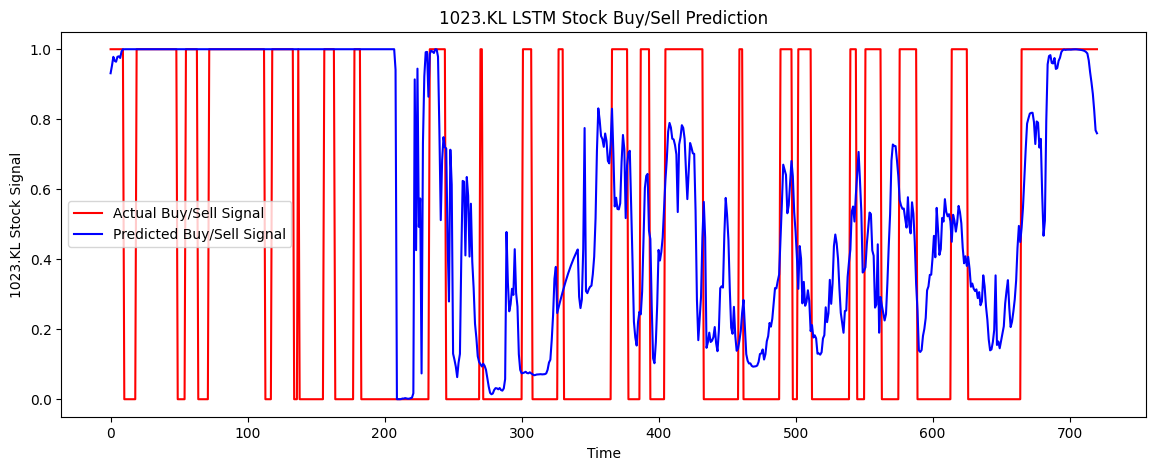

In [564]:
# Testing Initial Model 
# Printing Confusion Matrix, Classification Report, and Visualizing Predicted Signal
tf.keras.utils.plot_model(model, to_file='img/1023.KL-LSTM.png', show_shapes=True)
eval_model(model, X_test, y_test)